In [45]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def plot_learning_curve(estimator, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(estimator.__class__.__name__) + ' learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend().get_frame().set_facecolor('white')
    plt.show()

In [3]:
df_original = pd.read_csv('../DataMiningUniPi/dataset/customer_profile_kmeans.csv', sep='\t', index_col=0)
df = df_original.to_numpy()

# Decision Tree Classifier

In [104]:
data, label = df[:, :-1], df[:, -1]
train_data, test_data, train_label, test_label = tts(data, label, test_size=0.25, random_state=42, stratify=label)

pipeline = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())])

param_grid = {'dt__splitter':['best', 'random'],
              'dt__max_depth':(10, 30, 60, 100, 200, 500),
              'dt__min_samples_split':(2, 5, 10, 15, 20, 30),
              'dt__min_samples_leaf':(1, 2, 4, 7, 10, 15),
              'dt__max_features':(1, 'auto', 5, 7, 10, 15),
              'dt__criterion':('gini', 'entropy')
             }

dt_grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(train_data, train_label)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 18480 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:  1.2min finished


In [46]:
with open('grid_decision_tree', 'rb') as fp:
    dt_grid = pickle.load(fp)

In [12]:
results = pd.DataFrame(dt_grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score' ]].sort_values('rank_test_score')
results.rename(columns={'mean_test_score':'mean_validation_score', 'rank_test_score':'rank_validation_score'}, inplace=True)

In [13]:
print(results.iloc[0].params)
print(results.iloc[0])

{'dt__criterion': 'entropy', 'dt__max_depth': 60, 'dt__max_features': 7, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__splitter': 'best'}
params                   {'dt__criterion': 'entropy', 'dt__max_depth': ...
mean_train_score                                                         1
mean_validation_score                                             0.931513
rank_validation_score                                                    1
Name: 3672, dtype: object


## Evaluating on the test set

In [47]:
dt_test_predictions = dt_grid.best_estimator_.predict(test_data)
accuracy_score(dt_test_predictions, test_label)

0.9372623574144486

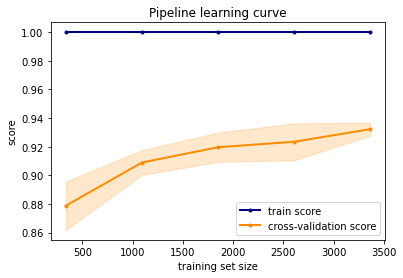

In [30]:
plot_learning_curve(dt_grid.best_estimator_, data, label)

[Text(180.66617647058825, 209.07692307692307, 'X[0] <= 0.182\nentropy = 1.475\nsamples = 3154\nvalue = [1144, 530, 1480]'),
 Text(70.84411764705884, 192.35076923076923, 'X[6] <= -0.855\nentropy = 1.045\nsamples = 1817\nvalue = [54, 525, 1238]'),
 Text(23.797058823529415, 175.62461538461537, 'X[2] <= -0.761\nentropy = 0.713\nsamples = 537\nvalue = [0, 432, 105]'),
 Text(8.75294117647059, 158.89846153846153, 'X[7] <= -0.254\nentropy = 0.16\nsamples = 342\nvalue = [0, 334, 8]'),
 Text(4.376470588235295, 142.1723076923077, 'X[1] <= -0.924\nentropy = 0.075\nsamples = 330\nvalue = [0, 327, 3]'),
 Text(2.1882352941176473, 125.44615384615385, 'entropy = 0.0\nsamples = 300\nvalue = [0, 300, 0]'),
 Text(6.564705882352942, 125.44615384615385, 'X[5] <= -0.291\nentropy = 0.469\nsamples = 30\nvalue = [0, 27, 3]'),
 Text(4.376470588235295, 108.72, 'X[2] <= -1.255\nentropy = 0.811\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(2.1882352941176473, 91.99384615384615, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1

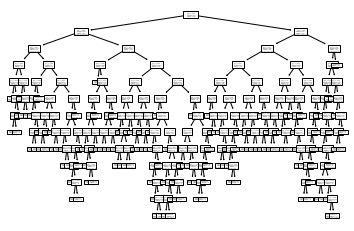

In [47]:
plot_tree(dt_grid.best_estimator_['dt'])

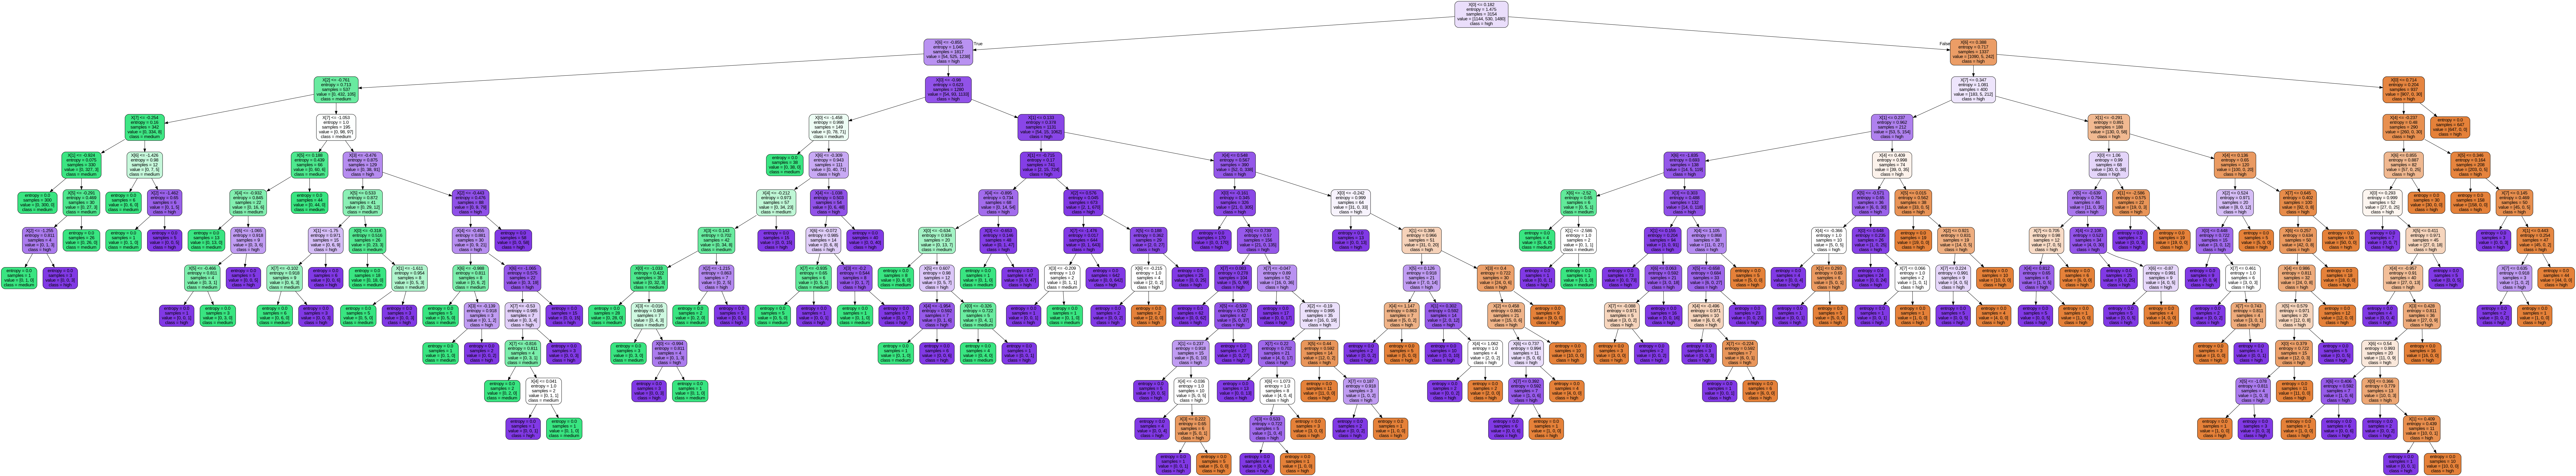

In [50]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt_grid.best_estimator_['dt'], out_file=None, 
                         #feature_names=list(train_set.columns),  
                         class_names=label,  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<AxesSubplot:>

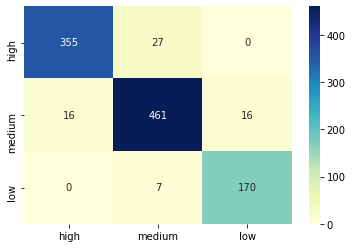

In [92]:
confusion = pd.DataFrame(confusion_matrix(test_label, dt_test_predictions, labels=['high', 'medium', 'low']), columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
confusion
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu')

In [53]:
print(classification_report(test_label, dt_test_predictions, labels=test_label, target_names=['high', 'medium', 'low']))

              precision    recall  f1-score   support

        high       0.93      0.94      0.93       493
      medium       0.93      0.94      0.93       493
         low       0.96      0.93      0.94       382

    accuracy                           0.94    420302
   macro avg       0.94      0.94      0.94    420302
weighted avg       0.94      0.93      0.94    420302



# Random Forest Classifier

## First Grid Search

In [30]:
data, label = df[:, :-1], df[:, -1]
train_data, test_data, train_label, test_label = tts(data, label, test_size=0.25, random_state=42, stratify=label)

pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

param_grid = {'rf__n_estimators':(10, 100, 1000),
              'rf__bootstrap':(True, False),
              'rf__max_depth':(10, 30, 60, 100),
              'rf__min_samples_split':(2, 5, 10),
              'rf__min_samples_leaf':(1, 2, 4),
              'rf__max_features':(1, 'auto', 5),
             }

rf_grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(train_data, train_label)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 28.7min finished


In [54]:
with open('grid_random_forest', 'rb') as fp:
    rf_grid = pickle.load(fp)

In [55]:
results = pd.DataFrame(rf_grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score' ]].sort_values('rank_test_score')
results.rename(columns={'mean_test_score':'mean_validation_score', 'rank_test_score':'rank_validation_score'}, inplace=True)

In [56]:
print(results.iloc[0].params)
print(results.iloc[0])

{'rf__bootstrap': True, 'rf__max_depth': 60, 'rf__max_features': 1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000}
params                   {'rf__bootstrap': True, 'rf__max_depth': 60, '...
mean_train_score                                                         1
mean_validation_score                                             0.960047
rank_validation_score                                                    1
Name: 167, dtype: object


In [21]:
rf_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=60, max_features=1,
                                        min_samples_split=5,
                                        n_estimators=1000))])

## Evaluation on the test set

In [57]:
rf_test_predictions = rf_grid.best_estimator_.predict(test_data)
accuracy_score(rf_test_predictions, test_label)

0.9724334600760456

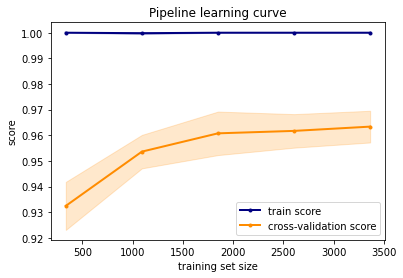

In [28]:
plot_learning_curve(rf_grid.best_estimator_, data, label)

<AxesSubplot:>

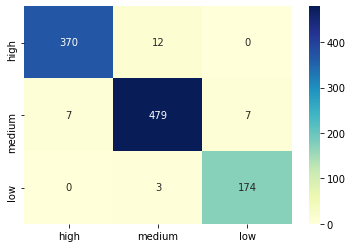

In [58]:
confusion = pd.DataFrame(confusion_matrix(test_label, rf_test_predictions, labels=['high', 'medium', 'low']), columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu')

In [60]:
print(classification_report(test_label, rf_test_predictions, labels=test_label, target_names=['high', 'medium', 'low']))

              precision    recall  f1-score   support

        high       0.97      0.97      0.97       493
      medium       0.97      0.97      0.97       493
         low       0.98      0.97      0.97       382

    accuracy                           0.97    420302
   macro avg       0.97      0.97      0.97    420302
weighted avg       0.97      0.97      0.97    420302



## Second Grid Search

### Since the best result is with 1000 estimators, I try another grid search with more estimators, to see if the results are better

In [77]:
data, label = df[:, :-1], df[:, -1]
train_data, test_data, train_label, test_label = tts(data, label, test_size=0.25, random_state=42, stratify=label)

pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

param_grid = {'rf__n_estimators':(1500, 2000, 3000, 4000),
              'rf__bootstrap':(True, False),
              'rf__max_depth':(10, 30, 60, 100),
              'rf__min_samples_split':(2, 5, 10),
              'rf__min_samples_leaf':(1, 2, 4),
              'rf__max_features':(1, 'auto', 5),
             }

grid_after = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(train_data, train_label)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 72.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 109.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 149.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 205.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 275.4min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 307.8min finished


In [8]:
with open('grid_after_random_forest', 'rb') as fp:
    rf_grid_after = pickle.load(fp)

In [9]:
results_after = pd.DataFrame(rf_grid_after.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score' ]].sort_values('rank_test_score')
results_after.rename(columns={'mean_test_score':'mean_validation_score', 'rank_test_score':'rank_validation_score'}, inplace=True)

In [10]:
print(results_after.iloc[0].params)
print(results_after.iloc[0])

{'rf__bootstrap': True, 'rf__max_depth': 60, 'rf__max_features': 1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 2000}
params                   {'rf__bootstrap': True, 'rf__max_depth': 60, '...
mean_train_score                                                         1
mean_validation_score                                             0.960683
rank_validation_score                                                    1
Name: 221, dtype: object


### Comparing the two best results of the grid searches
All the parameters are the same except for *n_estimators*.

*n_estimators* = 1000 ------> *mean_validation_score* = 0.960047

*n_estimators* = 2000 ------> *mean_validation_score* = 0.960683

The difference is really small, maybe it's not worth to use 1000 estimators more

# Naive Bayes Classifier

In [61]:
data, label = df[:, :-1], df[:, -1]
train_data, test_data, train_label, test_label = tts(data, label, test_size=0.25, random_state=42, stratify=label)

pipeline = Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())])

gnb = pipeline.fit(train_data, train_label)

gnb_test_predictions = gnb.predict(test_data)

In [62]:
print(accuracy_score(gnb_test_predictions, test_label))
print("Number of mislabeled points out of a total %d points : %d" % (test_data.shape[0], (test_label != gnb_test_predictions).sum()))

0.967680608365019
Number of mislabeled points out of a total 1052 points : 34


<AxesSubplot:>

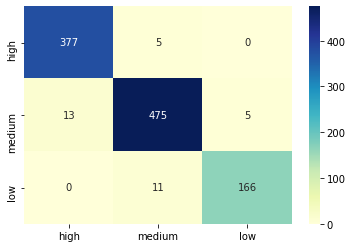

In [63]:
confusion = pd.DataFrame(confusion_matrix(test_label, gnb_test_predictions, labels=['high', 'medium', 'low']), columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu')

In [65]:
print(classification_report(test_label, gnb_test_predictions, labels=test_label, target_names=['high', 'medium', 'low']))

              precision    recall  f1-score   support

        high       0.97      0.96      0.97       493
      medium       0.97      0.96      0.97       493
         low       0.97      0.99      0.98       382

    accuracy                           0.97    420302
   macro avg       0.97      0.97      0.97    420302
weighted avg       0.97      0.97      0.97    420302



# KNN

In [33]:
data, label = df[:, :-1], df[:, -1]
train_data, test_data, train_label, test_label = tts(data, label, test_size=0.25, random_state=42, stratify=label)

pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors':[30, 50, 55, 60, 65, 70, 75, 80, 85, 100],
              'knn__weights':['uniform', 'distance']
             }

knn_grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(train_data, train_label)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


In [36]:
results_knn = pd.DataFrame(knn_grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score' ]].sort_values('rank_test_score')
results_knn.rename(columns={'mean_test_score':'mean_validation_score', 'rank_test_score':'rank_validation_score'}, inplace=True)

In [37]:
print(results_knn.iloc[0].params)
print(results_knn.iloc[0])

{'knn__n_neighbors': 65, 'knn__weights': 'distance'}
params                   {'knn__n_neighbors': 65, 'knn__weights': 'dist...
mean_train_score                                                         1
mean_validation_score                                             0.980658
rank_validation_score                                                    1
Name: 9, dtype: object


## Evaluating on the test set

In [67]:
knn_test_predictions = knn_grid.best_estimator_.predict(test_data)
accuracy_score(knn_test_predictions, test_label)

0.9866920152091255

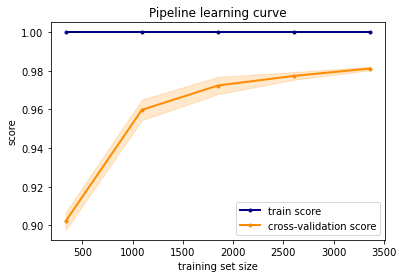

In [68]:
plot_learning_curve(knn_grid.best_estimator_, data, label)

<AxesSubplot:>

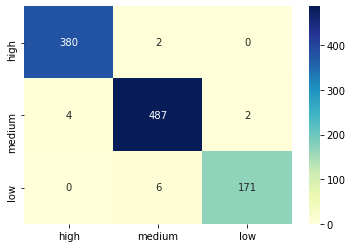

In [69]:
confusion = pd.DataFrame(confusion_matrix(test_label, knn_test_predictions, labels=['high', 'medium', 'low']), columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu')

In [71]:
print(classification_report(test_label, knn_test_predictions, labels=test_label, target_names=['high', 'medium', 'low']))

              precision    recall  f1-score   support

        high       0.98      0.99      0.99       493
      medium       0.98      0.99      0.99       493
         low       0.99      0.99      0.99       382

    accuracy                           0.99    420302
   macro avg       0.99      0.99      0.99    420302
weighted avg       0.99      0.99      0.99    420302

